In [1]:
import math
from functools import partial, reduce

import pandas as pd
import geopandas as gpd
import pyrosm
import pyproj
from shapely.ops import nearest_points, transform
from shapely.geometry import Polygon, Point

import contextily
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

In [2]:
# Читаем файл
df = pd.read_csv('train_test/train.csv', index_col=[0]).dropna()
# Добавляем геометрические точки по долготе и широте
df['geometry'] = [Point(xy) for xy in zip(df.long, df.lat)]
df['coordinates'] = [(xy) for xy in zip(df.long, df.lat)]
# Трансформируем фрейм в геофрейм
train = gpd.GeoDataFrame(df)
train.crs = 'epsg:4326'

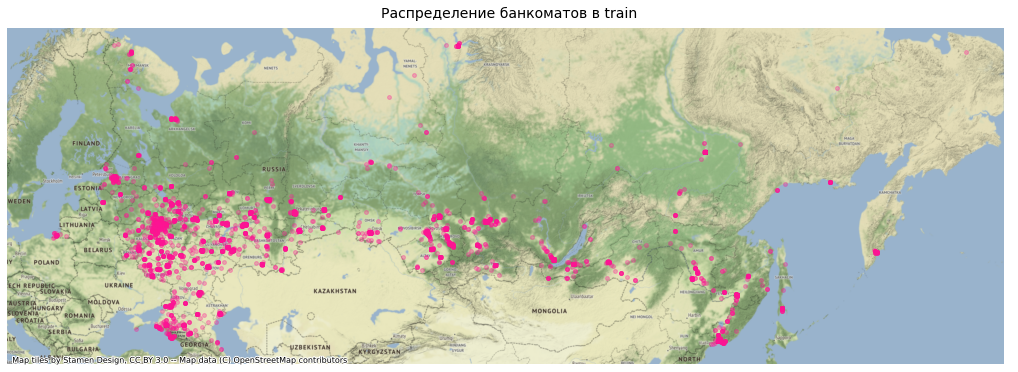

In [3]:
plot_data = train['geometry'].to_crs(epsg = 3857)
ax = plot_data.plot(markersize = 15, color = 'deeppink', alpha = 0.3, figsize=(18, 10))
contextily.add_basemap(ax)
plt.title('Распределение банкоматов в train', size = 14, pad = 10)
plt.axis('off')
plt.show()

In [4]:
# Если хочется интерактива
train.explore(color='deeppink')

#### Обогащение данных
Как мы видим из карты выше, наши банкоматы распределены по всей России. Для простоты, сузим область интереса до единственного города (Санкт-Петербурга) и обогатим имеющиеся данные дополнительными с помощью OSM.

In [5]:
# Выделяем Питер
spb_poly = Polygon([[29, 59.5], [31, 59.5], [31, 60.5], [29, 60.5]])
spb_data = train[train.geometry.within(spb_poly)]

In [6]:
spb_data.explore()

#### Примерный список параметров для обогащения:
1.  Расстояние до ближайшего соседнего банкомата
2.  Расстояние от банкомата до ближайшей станции метро
3.  Расстояние до ближайшего бизнес-центра
4.  Расстояние до ближайших школ, детских садов, университетов
5.  Расстояние до ближайших административных центров
6.  Количество кафе и других точек питания/магазинов/сервисов в определенном радиусе 
7.  Количество транспортных объектов в определенном радиусе

#### Из чего вытекает необходимость производить следующие действия:
* Загружать данные содержащие исходные координаты любых объектов инфратсруктура для осуществления обогащения
* Находить расстояние от банкомата до ближайшего объекта инфраструктуры
* Находить количество объектов инфраструктуры в определенном радиусе от банкомата 

In [7]:
# Список OSM тэгов
tag_list = [
    {'subway': True},
    {'public_transport': ['stop_position']},
    {'government': ['administrative']},
    {'amenity': ['college', 'university']},
    {'amenity': ['school']},
    {'amenity': ['kindergarten', 'childcare']},
    {'office': ['company']},
    {'amenity': ['cafe', 'fast_food', 'bar', 'pub', 'canteen']}
]

# Human-readable имена тегов 
tag_names = [
    'subway',
    'bus_stop',
    'gov_building',
    'college',
    'school',
    'kgarden',
    'office',
    'food'
]

In [8]:
# Читаем локальный осм дамп Питера
spb_dump = pyrosm.get_data('SanktPetersburg', directory='enrichment')
spb_osm = pyrosm.OSM(spb_dump)

In [9]:
def get_infrastructure(osm_obj, tag_list, tag_names):
    
    '''
    Возвращает словарь геофреймов с объектами инфраструктуры
    
    Keyword arguments:
    osm_obj -- объект OSM откудя тянем информацию по тегам
    tag_list -- лист со словарями тегов инфраструктуры
    tag_names -- human-readable ключ типа инфратсруктуры
    '''
    
    # инициализируем слвоарь аутпутов
    output = {}
    # аргументы для .get_data_by_custom_criteria
    node_filter = {'keep_ways': False, 'keep_relations': False} 
    
    # итерируемся над тегами и вытаскиваем информацию из OSM объекта
    for name, tag in zip(tag_names, tag_list):
        output[name] = osm_obj.get_data_by_custom_criteria(
            custom_filter=tag, **node_filter)
        
    return output

In [10]:
# Формируем словарь инфраструктурных геофреймов по Питеру
spb_infrastructure = get_infrastructure(spb_osm, tag_list, tag_names)

#### 1. Расстояние до ближайшего соседнего банкомата

In [11]:
def dist_to_nearest_neighbour(df, epsg = 3857):
    
    '''
    Считает минимальное расстояние до ближайшего соседнего банкомата
    
    df -- геофрейм с данными о банкоматах
    epsg -- желаемая проекция геофрейма (default:Pseudo-Mercator)
    '''
    
    df = df.copy().to_crs(epsg)
    df['nearest_atm'] = None
    for index, row in df.iterrows():
        point = row['geometry']
        multipoint = df.drop(index, axis=0)['geometry'].unary_union
        _, nearest_geom = nearest_points(point, multipoint)
        df.loc[index, 'nearest_atm'] = nearest_geom.distance(point)
        
    return df

In [12]:
spb_data = dist_to_nearest_neighbour(spb_data, epsg = 32636)

#### 2. Расстояние до ближаших объектов инфраструктуры

In [13]:
def dist_to_nearest_obj(atm, obj, epsg = 3857):
    
    '''
    Считает минимальное расстояние между объектами инфраструктры и банкоматом
    
    atm -- строчка из геофрейма с банкоматами
    infrastracture -- геофрейм с информацией об инфратсруктуре
    epsg -- желаемая проекция инфраструктурного геофрейма (default:Pseudo-Mercator)
    '''
    
    dist = min(obj.to_crs(epsg = epsg).distance(atm))
    return dist

In [14]:
for (name, infr) in spb_infrastructure.items():
    spb_data['nearest_{}'.format(name)] = \
        spb_data['geometry'].apply(dist_to_nearest_obj, obj=infr, epsg=32636)

#### 3. Количество объектов инфраструктуры в радиусе от банкомата

In [15]:
def geodesic_point_buffer(coords, m):
    
    '''
    Чертит корректный буфер вокург точки с учетом проекции
    
    coords -- tuple с долготой и широтой точки
    m -- радиус буфера
    '''
    
    lon, lat = coords
    proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84') 
    
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform, 
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    
    buf = Point(0, 0).buffer(m)
    
    return transform(project, buf)

In [16]:
def points_in_buffer(point_df, poly_df, name, m=250):

    '''
    Считает количество точек из points_df в каждом полигоне из poly_df

    point_df -- Геофрейм с объектами инфраструктуры
    poly_df -- Геофрейм с омновной информацией по банкоматам
    m -- Радиус для буффера
    '''
    
    point_df = spb_infrastructure[name]

    # Считаем буффер
    poly_df['{}m_buffer'.format(m)] = poly_df['coordinates'].apply(
        geodesic_point_buffer, m=m
    )
    # Меняем геометрию с точек на полигоны (буфферы)
    poly_df.set_geometry('{}m_buffer'.format(m), inplace=True)

    # Считаем количество точек из point_df в каждом полигоне из poly_df
    pts_in_poly = gpd.sjoin(point_df, poly_df, how='left')
    pts_in_poly['const'] = 1
    counter = pts_in_poly.groupby('index_right')['const'].sum()
    counter.name = '{}_in_{}m'.format(name, m)

    # Чистим фрейм от колонки буффера и возвращаем исходную геометрию
    poly_df.drop('{}m_buffer'.format(m), axis=1, inplace=True)
    poly_df.set_geometry('geometry', inplace=True)

    return counter

In [17]:
counter_list = []
for (name, infr) in spb_infrastructure.items():
    counter_list.append(points_in_buffer(infr, spb_data, name, 250))
    
dfs = [spb_data] + counter_list

In [18]:
df_final = reduce(lambda left, right: left.join(right), dfs).fillna(0)

In [19]:
df_final.explore()

In [21]:
df_final.to_csv('train_test/spb_enriched.csv')